In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

In [38]:
df = pd.read_csv("clean_technology_close.csv")

In [39]:
df.head()

,Date,ACIW,ACLS,ADBE,ADI,ADP,ADSK,AGYS,AMD,ASGN,...,LECO,LPSN,LRCX,MAN,MCHP,MDRX,MGRC,MIND,MPWR,MRVL
0,2019-03-13,33.139999,20.180000,264.380005,108.080002,152.839996,153.380005,20.420000,23.379999,63.860001,...,85.169998,28.590000,170.410004,84.339996,42.529999,10.56,57.180000,400.0,138.690002,19.690001
1,2019-03-14,33.279999,20.330000,267.690002,108.250000,153.509995,153.149994,20.420000,22.820000,64.660004,...,84.349998,28.879999,176.529999,84.019997,42.000000,10.45,57.270000,395.0,137.949997,19.410000
2,2019-03-15,33.650002,20.590000,257.089996,109.389999,155.309998,153.279999,20.480000,23.290001,64.559998,...,84.449997,28.510000,182.389999,84.510002,43.049999,10.63,57.830002,394.0,141.100006,20.139999
3,2019-03-18,33.389999,20.670000,257.760010,109.150002,154.690002,153.850006,20.360001,23.250000,65.370003,...,85.709999,28.580000,180.199997,85.440002,42.665001,10.45,58.720001,392.0,140.919998,19.950001
4,2019-03-19,33.180000,20.709999,260.420013,109.949997,154.630005,155.100006,20.360001,26.000000,64.980003,...,85.720001,28.889999,179.350006,85.000000,43.049999,10.46,58.520000,395.0,141.520004,20.230000


In [40]:
print(type(df.iloc[0]))

<class 'pandas.core.series.Series'>


In [41]:
# Daily return of each stock
returns = df.drop(["Date"], axis = 1).pct_change()

In [42]:
print(len(returns))

1260


In [43]:
# Correlation matrix using the daily return data
corr = returns.corr()

In [44]:
print(corr.shape)

(59, 59)


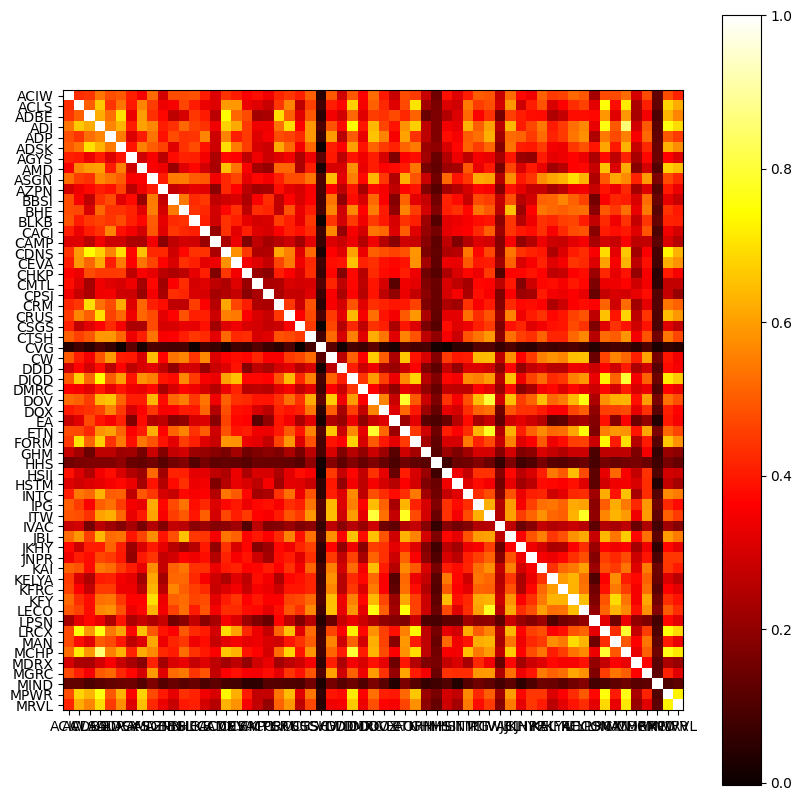

In [45]:
# Heatmap of the correlation matrix
plt.figure(figsize=(10, 10))
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar() 
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns)
plt.savefig("All_Stocks_Correlation_Heat_Map")
plt.show()


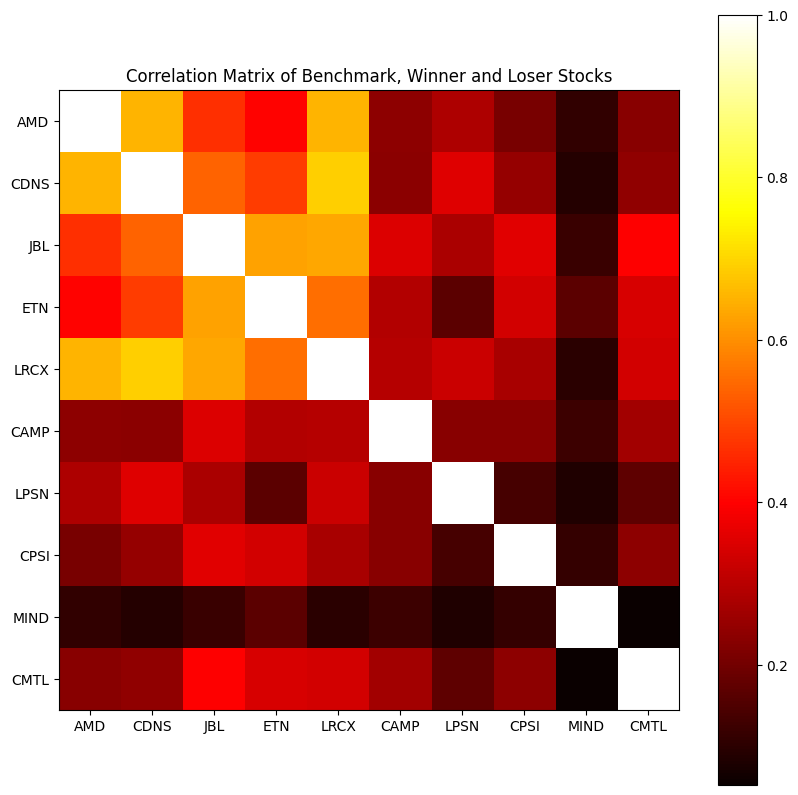

In [46]:
# Winners and Losers based on Sharpe
Winners = ["AMD", "CDNS", "JBL", "ETN", "LRCX"]
Losers = ["CAMP", "LPSN", "CPSI", "MIND", "CMTL"]
Combined = Winners+Losers

# Find correlation matrix between the above stocks
combined_corr = returns[Combined].corr()

# Heatmap of the correlation matrix
plt.figure(figsize=(10, 10))
plt.imshow(combined_corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(combined_corr)), combined_corr.columns)
plt.yticks(range(len(combined_corr)), combined_corr.columns)
plt.title('Correlation Matrix of Benchmark, Winner and Loser Stocks')
plt.savefig("Winners_Losers_Correlation_Heat_Map")
plt.show()

In [47]:
def plot_correlation_network(corr_matrix, img_title = None, threshold=0.5):
    G = nx.Graph()

    # Add nodes
    stocks = corr_matrix.columns
    G.add_nodes_from(stocks)

    # Add edges based on correlation threshold
    edges = []
    edge_colours = []
    edge_widths = []
    
    for i in range(len(stocks)):
        for j in range(i + 1, len(stocks)):  # Avoid duplicate edges
            weight = corr_matrix.iloc[i, j]
            if abs(weight) >= threshold:  # Apply threshold
                G.add_edge(stocks[i], stocks[j], weight=weight)
                edges.append((stocks[i], stocks[j]))
                
                # Colour edges: blue for positive, red for negative
                edge_colours.append((0, 0, abs(weight))) if weight > 0 else edge_colours.append((abs(weight), 0, 0)) 

                # Edge thickness based on correlation strength
                edge_widths.append(abs(weight) * 5)
                
    # Node colours: Green for winners, Red for losers
    node_colours = []
    for stock in stocks:
        if stock in Winners:
            node_colours.append("green")
        elif stock in Losers:
            node_colours.append("red")
        else:
            node_colours.append("lightblue")
            
    # Draw the graph
    plt.figure(figsize=(10, 6))
    pos = nx.circular_layout(G)  # Position nodes for visualization
    nx.draw(G, pos, with_labels=True, node_size=1000, node_color=node_colours, edge_color=edge_colours, width=edge_widths)
    
    # Draw edges with labels
    edge_labels = {(i, j): f"{w['weight']:.2f}" for i, j, w in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    
    plt.title(f"Stock Correlation Network (Threshold: {threshold})")
    plt.savefig(img_title)
    plt.show()

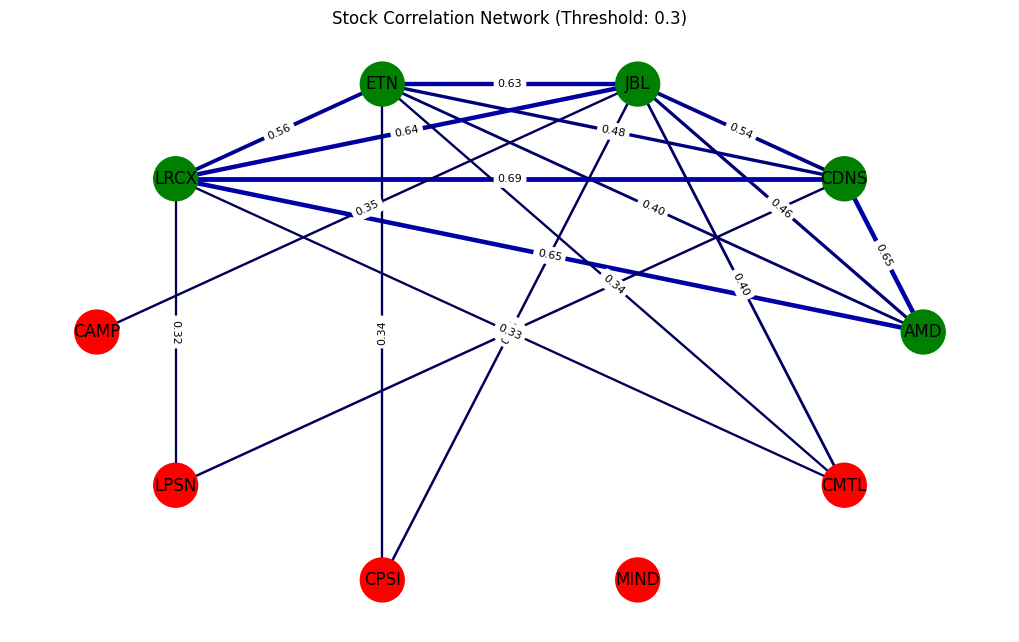

In [48]:
# Example usage with threshold 0.3
plot_correlation_network(combined_corr, "Winners_Losers_Network_Threshold", threshold=0.3)

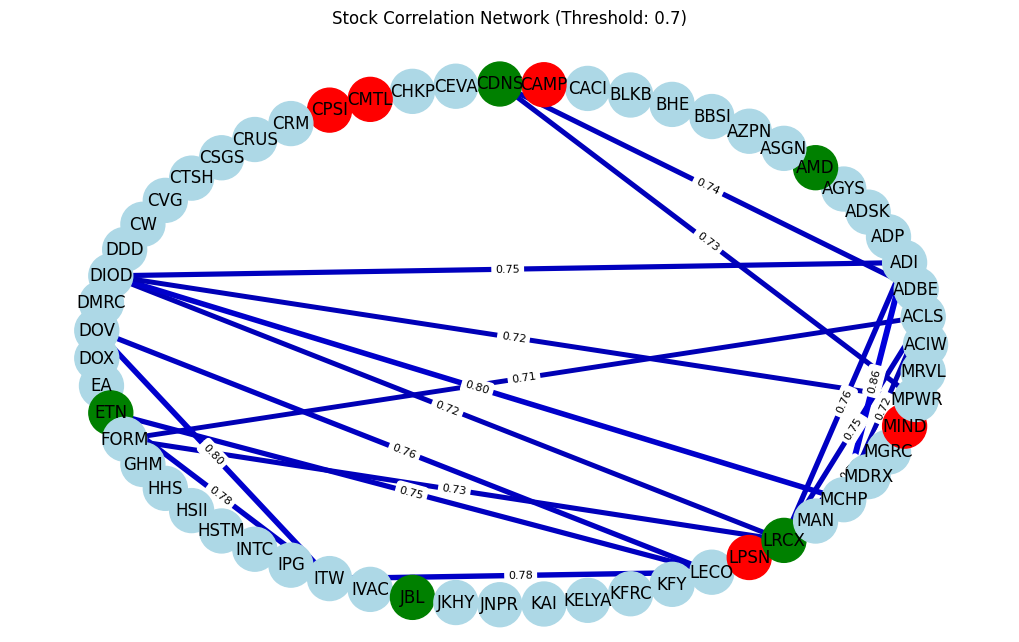

In [49]:
# Plot network for all stocks
plot_correlation_network(corr, "All_Stocks_Network", threshold=0.7)

In [50]:
def max_spanning_tree(corr_matrix):
    """
    Constructs a Maximum Spanning Tree (MST) from a correlation matrix.
    Keeps only the strongest connections to avoid clutter.
    """
    G = nx.Graph()
    
    # Add edges with negative weights (for MST computation)
    stocks = corr_matrix.columns
    for i in range(len(stocks)):
        for j in range(i + 1, len(stocks)):
            weight = corr_matrix.iloc[i, j]
            G.add_edge(stocks[i], stocks[j], weight=-weight)  # Use negative weight for MST
            
    # Compute MST (by default, NetworkX finds a Minimum Spanning Tree)
    mst = nx.minimum_spanning_tree(G, weight="weight")
    
    # Convert weights back to positive
    for u, v, d in mst.edges(data=True):
        d["weight"] = -d["weight"]

    return mst

def plot_mst(mst, corr_matrix, img_title):
    """
    Plots the Maximum Spanning Tree with edge weights.
    """
    # Node colours: Green for winners, Red for losers
    node_colours = []
    stocks = corr_matrix.columns
    for stock in stocks:
        if stock in Winners:
            node_colours.append("green")
        elif stock in Losers:
            node_colours.append("red")
        else:
            node_colours.append("lightblue")
            
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(mst, seed=42)  # Positioning

    # Draw nodes & edges
    nx.draw(mst, pos, with_labels=True, node_size=500, node_color=node_colours, edge_color="gray", font_size=10)

    # Draw edge labels with weights
    edge_labels = {(i, j): f"{w['weight']:.2f}" for i, j, w in mst.edges(data=True)}
    nx.draw_networkx_edge_labels(mst, pos, edge_labels=edge_labels, font_size=8)

    plt.title("Maximum Spanning Tree of Stock Correlations")
    plt.savefig(img_title)
    plt.show()
    
def compute_degree_centrality(mst):
    """
    Computes degree centrality of each node in the MST.
    Returns a sorted dictionary of stocks by centrality.
    """
    centrality = nx.degree_centrality(mst)  # Compute centrality
    return dict(sorted(centrality.items(), key=lambda x: x[1], reverse=True))  # Sort by importance


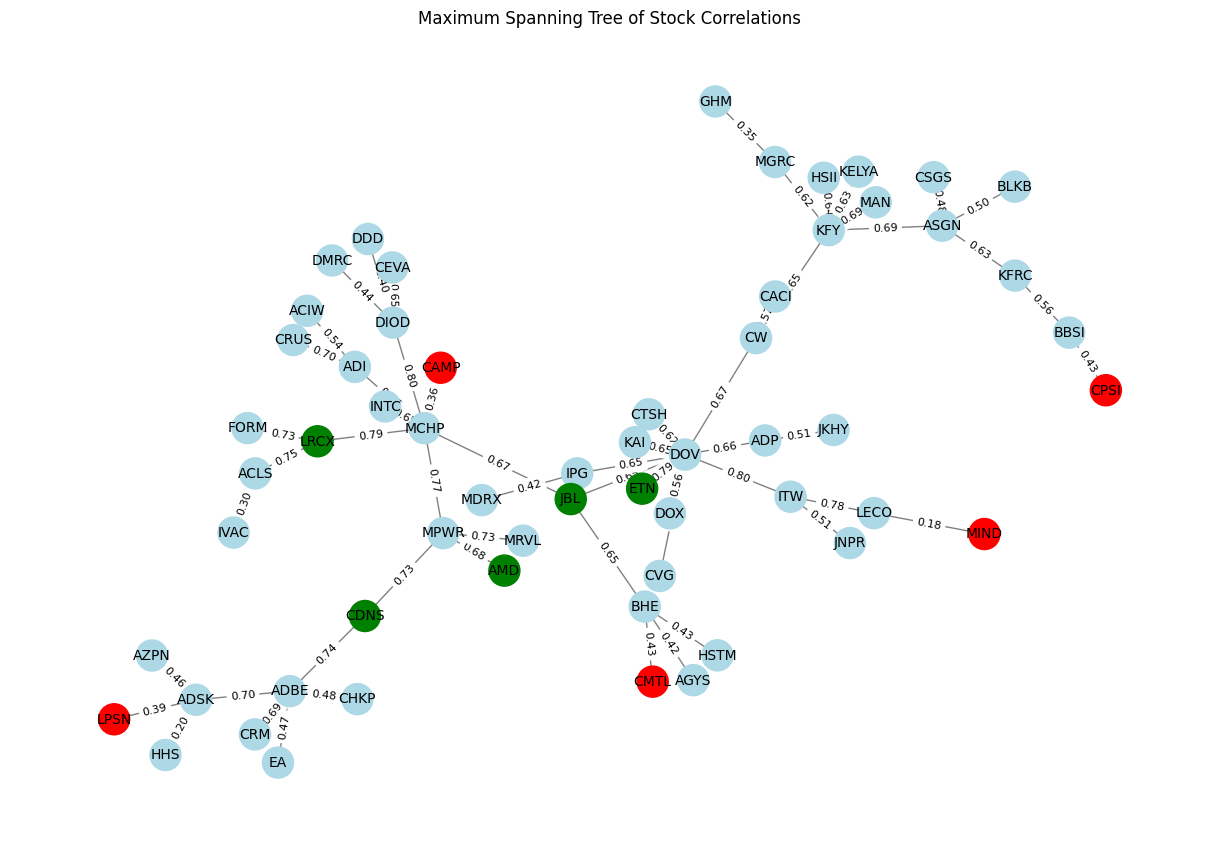

In [51]:
# Generate the MST
mst = max_spanning_tree(corr)

# Plot the MST
plot_mst(mst, corr, "All_Stocks_Max_Spanning_Tree")

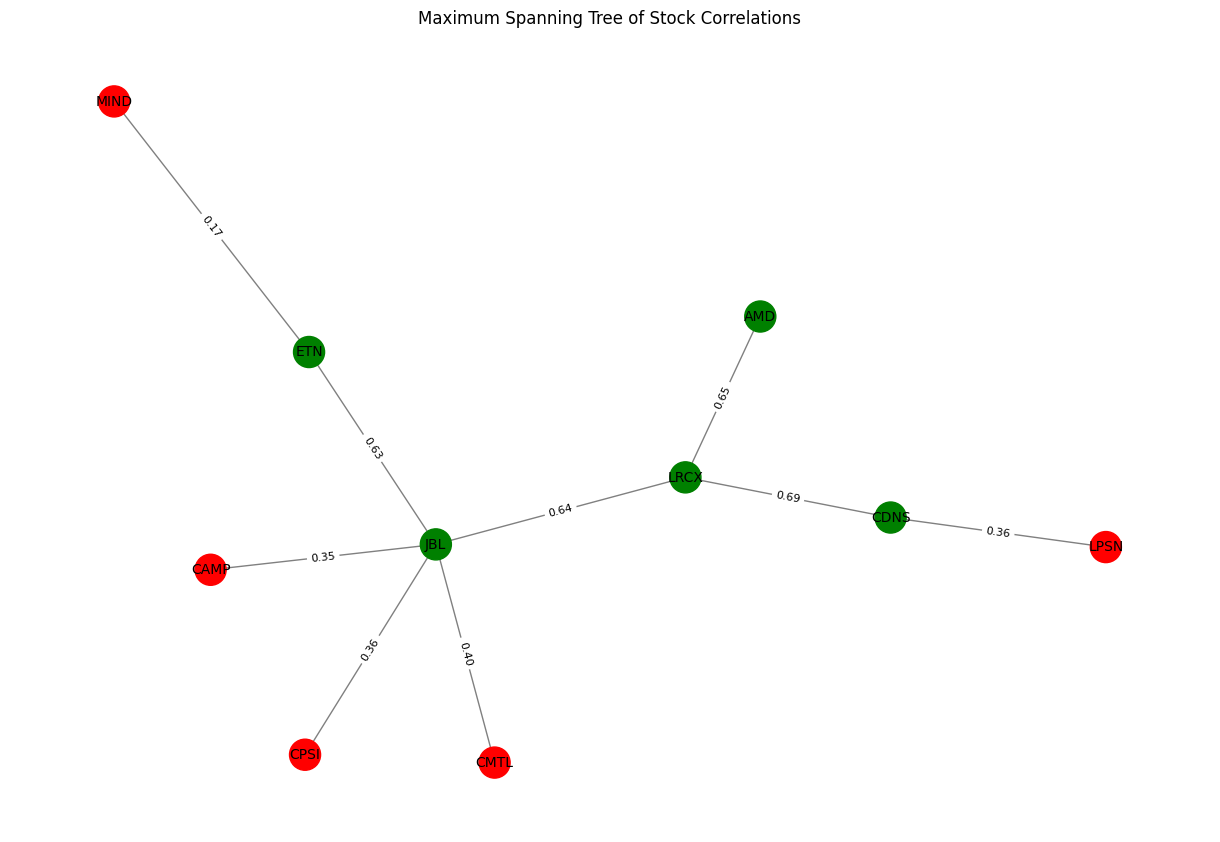

In [52]:
# MST for the 10 stocks
combined_mst = max_spanning_tree(combined_corr)
plot_mst(combined_mst, combined_corr, "Winners_Losers_Max_Spanning_Tree")